In [2]:
#importing some useful packages
#Cell 1

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
import glob
import pickle

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#allImages = os.listdir("test_images/")

%matplotlib inline

In [4]:
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [6]:
#All of my functions are now here
#cell 2

xm_per_pix = 3.7/900

def cal_undistort(img, mtx, dist):
    undist= cv2.undistort(img,mtx,dist,None,mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary

'''

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)#.astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary_gray = np.zeros_like(sxbinary)
    combined_binary_gray[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary_gray

'''

# Retuns binary image based on thresholding functions
def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    light_mask[(S >= 5) & (L >= 130)] = 1

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresh(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
    gradx_s = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    combined = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # Mix results from either channels
    combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    
    return combined


def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return Minv,warped

def getLeftAndRightAngle(binary_warped):
    #Need to convert this to grayscalle as well
    
    
    #Dont have to do below anymore
    #binary_warped = binary_warped[:, :, 0]

    #code from lecture

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    #For getiing radius starts now
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    leftx=np.resize(leftx,ploty.shape)
    rightx= np.resize(rightx,ploty.shape)
    
    #Radius in pixel space
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    #Radius in real space
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return ploty,left_fitx,right_fitx,left_curverad, right_curverad


'''
def getPts(left_fitx,right_fitx, ploty):
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    return pts
'''


def drawLanePoly(image, Minv,warped,pts):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #color_warp = np.dstack(warp_zero)

    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    '''
    Removed from here,this was taking global variable
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    '''
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result


def find_position_wrt_center(pts,image_shape):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    
    
    center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

#You have to call processImage on every Image
def process_image(image):
    undistortedImage = cal_undistort(image,mtx,dist)
    #color_binary,combined_binary_gray = pipeline(undistortedImage)
    
    combined_binary_gray = get_binary_image(undistortedImage)
    
    src=np.array([[240, 700], [580,460],[710,460], [1110,700] ],np.float32)
    dst=np.array([[220, 700], [220,20],[1110 ,20], [1110,700] ],np.float32)

    Minv,warpedImage = warper(combined_binary_gray,src,dst)
    
    ploty,left_fitx,right_fitx,left_curverad, right_curverad = getLeftAndRightAngle(warpedImage)
    
    #pts = getPts(left_fitx,right_fitx, ploty)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    
    polyImage = drawLanePoly(undistortedImage,Minv,warpedImage,pts)
    
    #Get center
    mid = (left_fitx[-1]+right_fitx[-1])/2
    center_image = image.shape[1]/2
    offset = (center_image - mid)*xm_per_pix#to conver to meters
    
    center = "Vehicle position w.r.t center '{0}'".format(offset)
    cv2.putText(polyImage,center, (40,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
    
    radius = (left_curverad + right_curverad)/2
    text = "Radius of curvature '{0}' ".format(radius)
    cv2.putText(polyImage,text, (40,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
    
    return polyImage

print('all functions defined')





all functions defined


In [14]:
#Camera Callibaration - get imagePoints and objectPoints for all images 
#Step not needed 2nd time
#Cell 3

%matplotlib inline

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cali*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        
        #below comment added to avoid showing image in new window
        #cv2.imshow('img', img)
        
        
        
        cv2.waitKey(500)

cv2.destroyAllWindows()
print('Done')


Done


In [15]:
#Take one image, calibrate camera and get all camera co-efficients
#Step not needed 2nd time
#Cell 4

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration10.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


#Code for getting perspective transform M 

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
M='none'

if ret == True:
    #print('corners are',corners)
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

#Code for getting perspective transform M ends



'''
src – Input (distorted) image.
dst – Output (corrected) image that has the same size and type as src .
cameraMatrix – Input camera matrix  A = \vecthreethree{f_x}{0}{c_x}{0}{f_y}{c_y}{0}{0}{1} .
distCoeffs – Input vector of distortion coefficients  (k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6]]) of 4, 5, or 8 elements. If the vector is NULL/empty, the zero distortion coefficients are assumed.
newCameraMatrix – Camera matrix of the distorted image. By default, it is the same as cameraMatrix but you may additionally scale and shift the result by using a different matrix.
'''
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["M"] = M

pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

'''
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
'''

print ('Done')


Done


Done


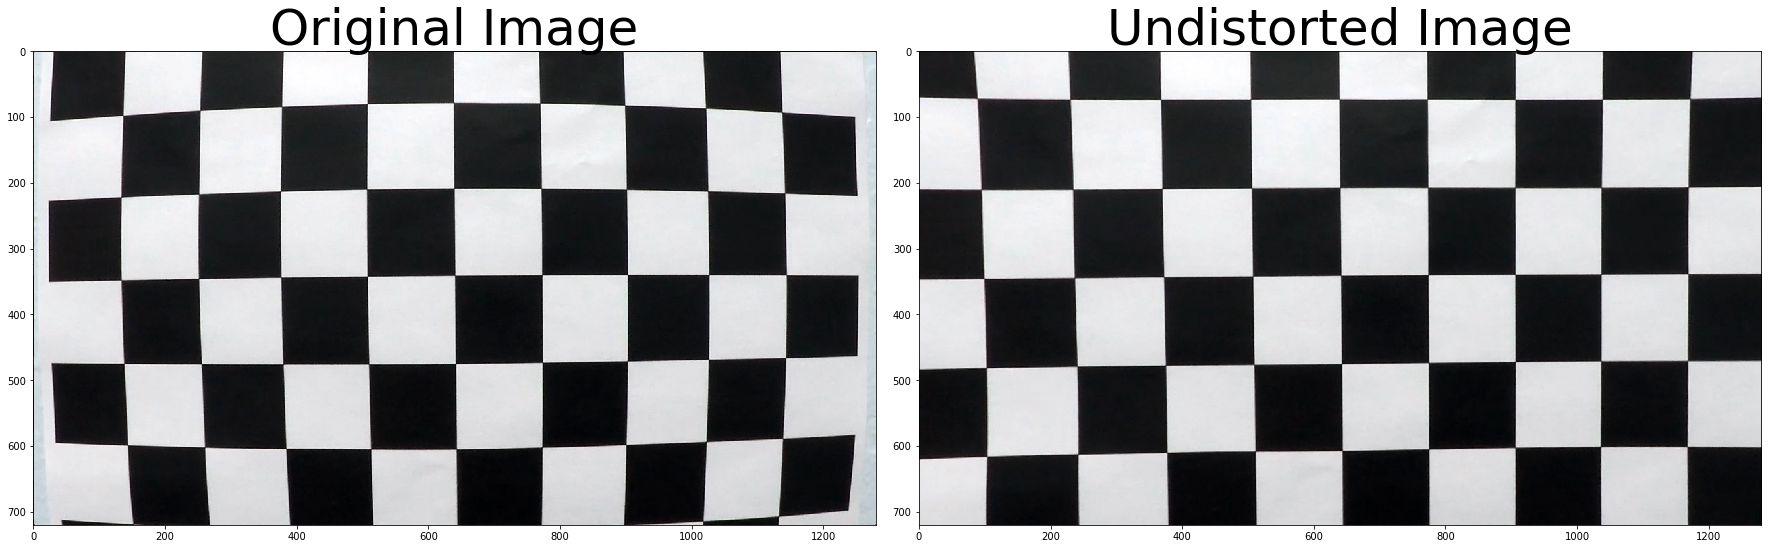

In [5]:
#load mtx and dist from saved data 
#Cell 5
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M=dist_pickle["M"]


# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#print (gray.shape,gray.shape[::-1])

undistorted = cal_undistort(img, mtx, dist)

print ('Done')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




Done


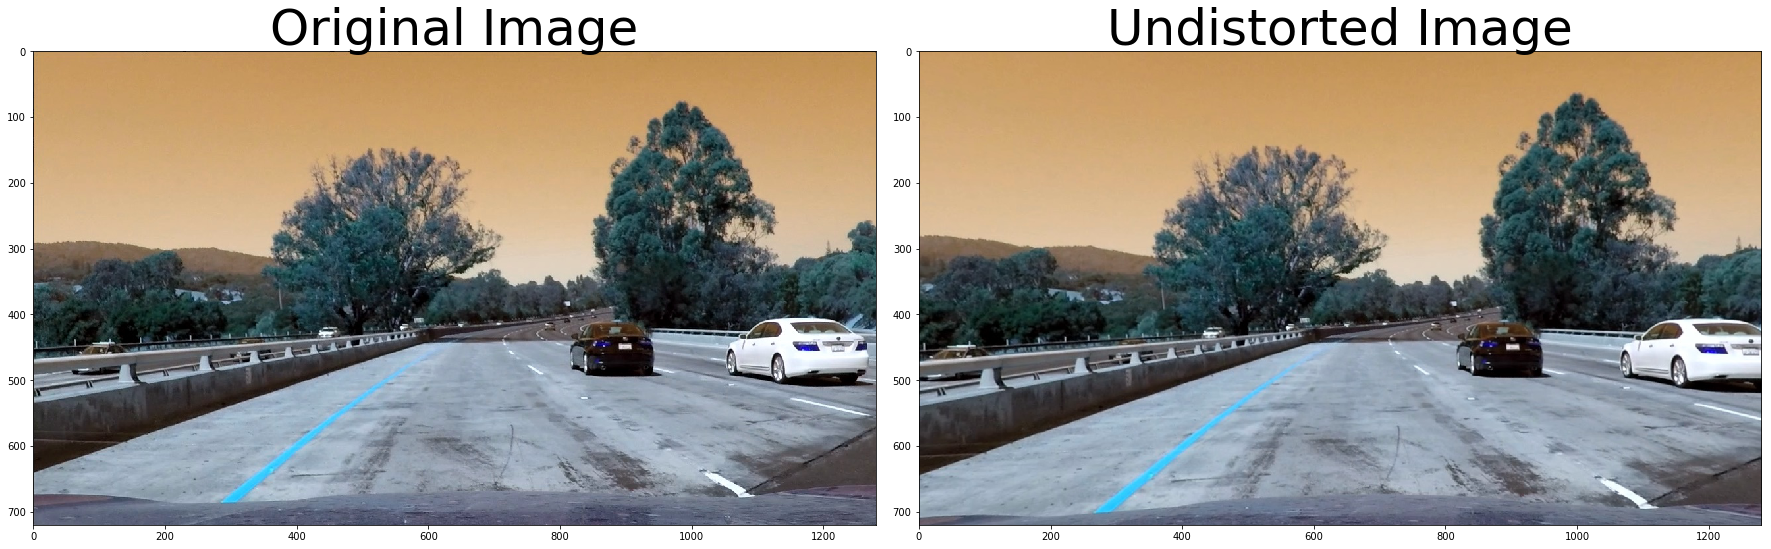

In [6]:
#distortion correction on test image
#Cell 6

# Read in an image
img = cv2.imread('test_images/test1.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#print (gray.shape,gray.shape[::-1])

undistorted = cal_undistort(img, mtx, dist)

print ('Done')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [3]:
#Color and gradient thresold
#Cell 7

'''
#image = mpimg.imread('test6.jpg')
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))


#Combine the output of both of above process
combined = np.zeros_like(dir_binary)
combined[((mag_binary == 1) & (dir_binary == 1))] = 1



 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
    
hls_binary = hls_select(image, thresh=(90, 255))

'''

#Home of pipeline function

print ('pipeline function defined')


pipeline function defined


640.0


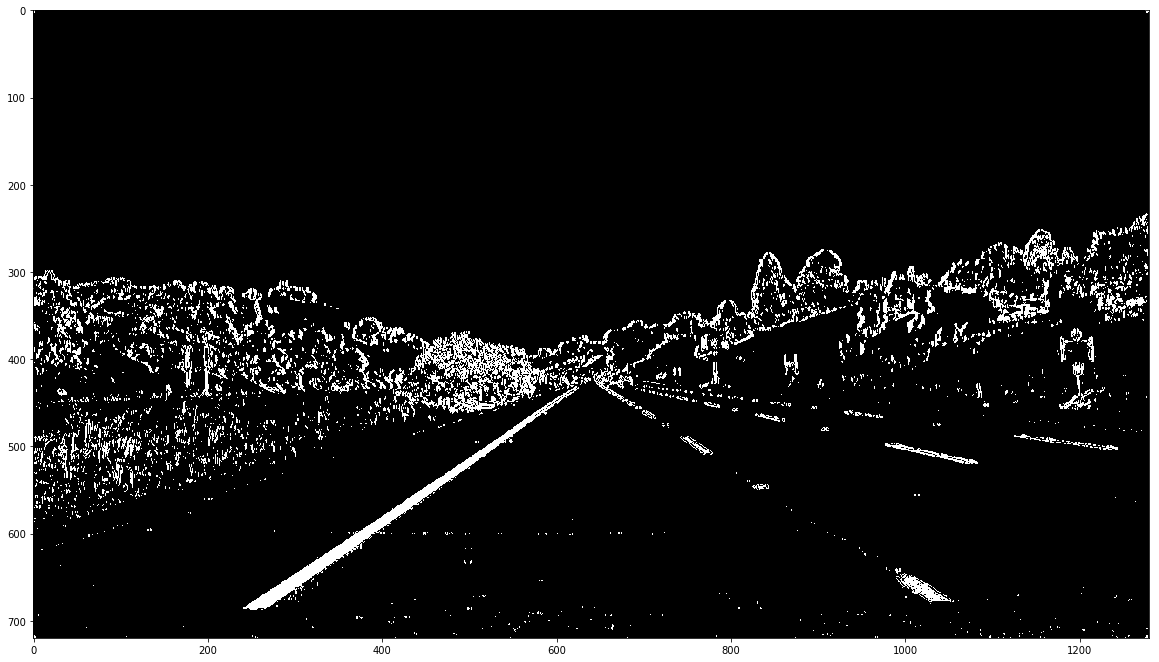

In [48]:
#Perspective Transform
#Cell 8
%matplotlib inline


image = mpimg.imread('test_images/straight_lines1.jpg')
center_image=image.shape[1]/2
print(center_image)
result,combined_binary_gray = pipeline(image)
#wrapped = warper(combined_binary_gray)

#plt.imshow(masked_image)

plt.figure(figsize=(20,20))
plt.imshow(combined_binary_gray,cmap='gray')
#

process image function defined


In [4]:
#One time operation get the images from video
#Cell 9


print('Started operation')
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
while success:
    
    #print ('Read a new frame: ', success
    processed= process_image(image)
    
    '''
        #Might  not need this since we are now returning undistoted color image ,lets see
    
    #The image u have is a 0-1 image not 0-255 image,imwrite treates all points as black points so 
    #so multiply all points by 255 to SAVE correct output in file
    processed=processed*255
    #plt.figure(figsize=(10,10))
    #plt.imshow(processed)
    '''
    
    
    cv2.imwrite("output/asd%d.jpg" % count, processed)     # save frame as JPEG file
    count += 1
    success,image = vidcap.read()
    
print('Done')

Started operation
Done


Done


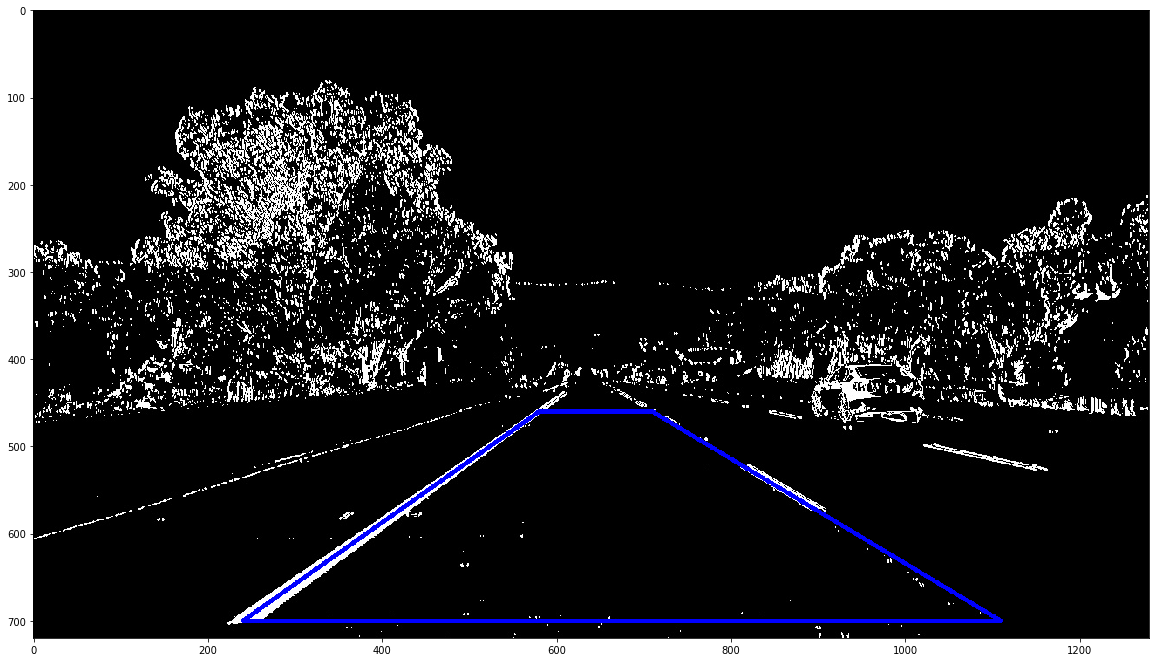

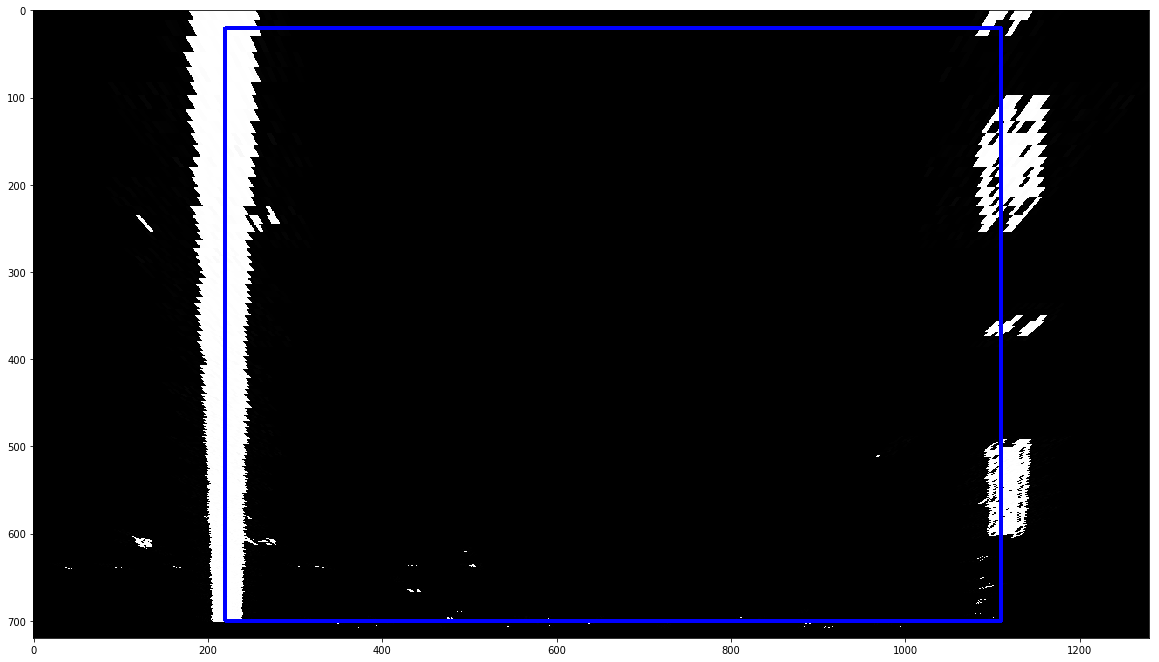

In [38]:
#One time operation get src and dst arrays for all the images ,
#add the warper function to your pipeline with these src and dst
#Add warper to pipeline function
#Cell 10

image = cv2.imread('final500.jpg')
points = np.array([[240, 700], [580,460],[710,460], [1110,700] ])
cv2.polylines(image,[points],True, (0,0,255),3) 

plt.figure(figsize=(20,20))
plt.imshow(image,cmap='gray')


#imp to add float 32 otherwise gives some error
src=np.array([[240, 700], [580,460],[710,460], [1110,700] ],np.float32)
dst=np.array([[220, 700], [220,20],[1110 ,20], [1110,700] ],np.float32)

image = cv2.imread('final500.jpg')
Minv, warpedImage = warper(image,src,dst)

#not here though

points = np.array([[220, 700], [220,20],[1110 ,20], [1110,700] ])
cv2.polylines(warpedImage,[points],True, (0,0,255),3) 


plt.figure(figsize=(20,20))
plt.imshow(warpedImage,cmap='gray')


print('Done')
#Save M for one image and use it later







In [31]:
##This is not needed
##now get M here for all the images

dist_pickle = pickle.load( open( "perspectiveTransform.p", "rb" ) )
M=dist_pickle["M"]

print('M is ',M)


M is  [[ -7.26777816e-01  -1.58744471e+00   1.11121130e+03]
 [ -9.21485110e-15  -2.10854032e+00   9.67233753e+02]
 [ -1.43114687e-17  -2.46682545e-03   1.00000000e+00]]


In [41]:
##checking how to remove 3rd dimention of array

x = warpedImage

result = x[:, :, 0]
print (result.shape)
print(x.shape)

(720, 1280)
(720, 1280, 3)


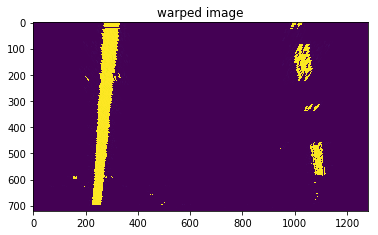

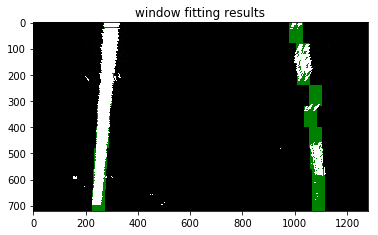

Done


In [22]:
#Sliding window search on Warped image i.e after pipeline function
# This works but i dont use it in my project
%matplotlib inline

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

# Read in a thresholded image

def getWindowFittedResults(warpedImage,showPlot):

    warped = warpedImage
    warped = warped[:, :, 0]

    if(showPlot):
        plt.imshow(warped)
        plt.title('warped image')
        plt.show()
    

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    l_points =None
    r_points =None
   
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    

    # Display the final results
    if(showPlot):
        plt.imshow(output)
        plt.title('window fitting results')
        plt.show()
        
    

    return l_points,r_points,output

l_points,r_points,windowFitted = getWindowFittedResults(warpedImage,True)

print('Done')



In [39]:
#Using 2nd method
#Cell 11

#Need to convert this to grayscalle as well
binary_warped = warpedImage
binary_warped = binary_warped[:, :, 0]

#code from lecture

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)



(720, 0)

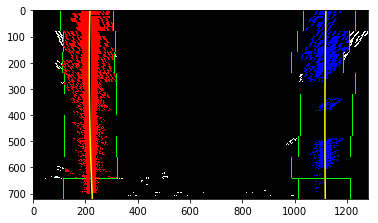

In [40]:
#Visulization

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720,)   (55166,) (25100,)


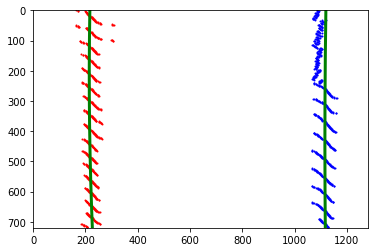

In [41]:
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#Cell 12

ploty = np.linspace(0, warpedImage.shape[0]-1, warpedImage.shape[0] )

quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(ploty.shape,' ',leftx.shape,rightx.shape)
leftx=np.resize(leftx,ploty.shape)
rightx= np.resize(rightx,ploty.shape)

# Plot up the fake data
mark_size = 1
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [47]:
print(left_fit,' \n ',left_fitx.shape,' ',left_fitx[0],' ',right_fitx[0])

[  4.71122950e-05  -2.06749424e-02   2.17073954e+02]  
  (720,)   217.073954395   1119.42721751


In [109]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

10648.2349982 25777.9688466


In [110]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

59409.0322943 m 1682.99098118 m


In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#print('image is ',white_clip)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [01:24<00:00, 14.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 5s, sys: 25.5 s, total: 1min 31s
Wall time: 1min 24s


In [59]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
new_a = np.resize(a, 4)

print(new_a) #Prints `[1, 2, 5, 6, 8, 9]`

[1 2 3 4]


59409.0322943  1682.99098118


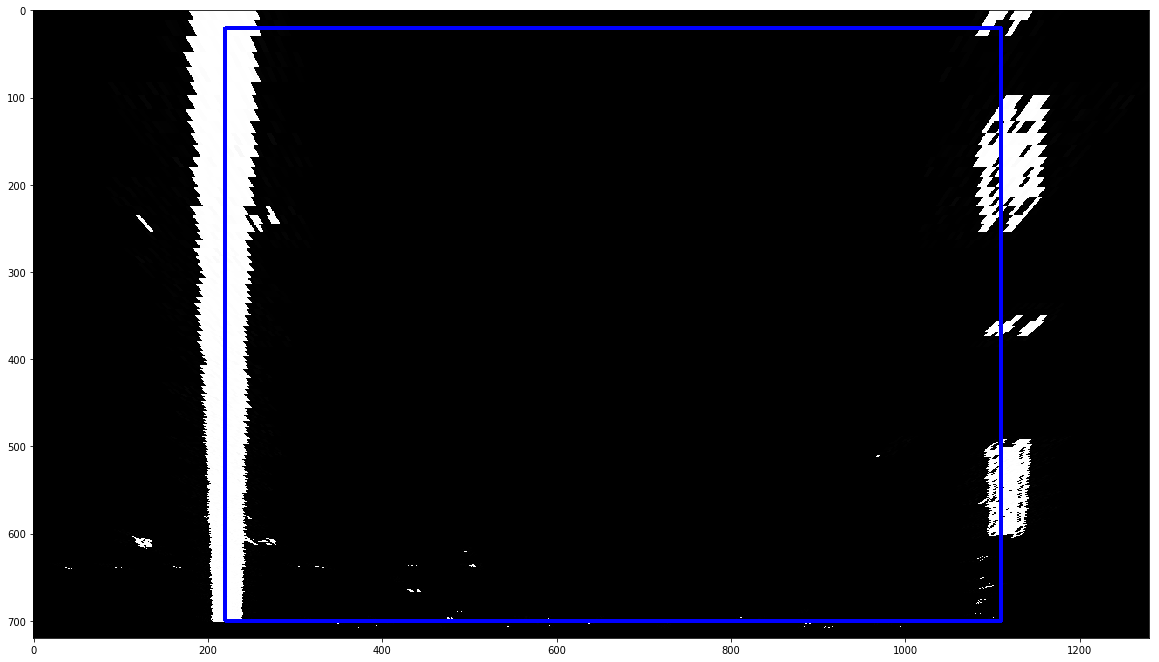

In [111]:

left_curverad, right_curverad = getLeftAndRightAngle(warpedImage);

'''

left_curverad, right_curverad = getLeftAndRightAngle(warpedImage);
text = "left radius '{0}' right radius '{1}'".format(left_curverad ,right_curverad)
cv2.putText(warpedImage,text, (40,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))

plt.figure(figsize=(20,20))
plt.imshow(warpedImage)
'''

print(left_curverad,'', right_curverad)
plt.figure(figsize=(20,20))
plt.imshow(warpedImage)
#cv2.imwrite("sample/aaa.jpg" , warpedImage)

In [117]:
#print(left_fitx)
print(M,type(M))

inverse = np.linalg.inv(M)
print(inverse)

[[  1.75598563e+00   1.49736803e-02  -8.85256777e+02]
 [  5.53556854e-03   1.50367559e+00  -4.41396091e+02]
 [ -1.77072520e-04  -3.75596606e-04   1.00000000e+00]] <class 'numpy.ndarray'>
[[  6.32113254e-01   1.50021627e-01   6.25801502e+02]
 [  3.43125014e-02   7.55589827e-01   3.63889770e+02]
 [  1.24817546e-04   3.10361682e-04   1.24748801e+00]]


(720, 1280, 3)
[[[  2.17073954e+02   0.00000000e+00]
  [  2.17053327e+02   1.00000000e+00]
  [  2.17032793e+02   2.00000000e+00]
  ..., 
  [  1.11939326e+03   2.00000000e+00]
  [  1.11941022e+03   1.00000000e+00]
  [  1.11942722e+03   0.00000000e+00]]]


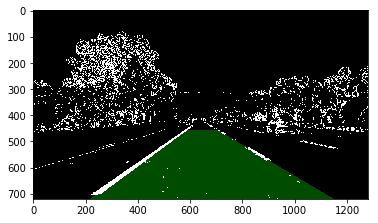

In [139]:
#Fir a poly on the original image

image = cv2.imread('sample/frame_black500.jpg')
plt.imshow(image)

#Minv = np.linalg.inv(M)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = warpedImage

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#color_warp = np.dstack(warp_zero)

color_warp=warp_zero

print(color_warp.shape)


# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))


print(pts)
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [52]:
mid = (left_fitx[0]+right_fitx[0])/2
center_image = warpedImage.shape[1]/2
offset = (center_image - mid)*xm_per_pix#to conver to meters

print(offset)

-0.14932452575


In [7]:
#Processing the video as shown in youtube video by reviewer
white_output = 'outputNew.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#print('image is ',white_clip)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video outputNew.mp4
[MoviePy] Writing video outputNew.mp4


100%|█████████▉| 1260/1261 [03:24<00:00,  6.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: outputNew.mp4 

CPU times: user 3min 24s, sys: 40.2 s, total: 4min 4s
Wall time: 3min 26s
